In [89]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import io, stats, spatial
from fooof import FOOOFGroup

sys.path.append('../')
import utils

font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 14}

import matplotlib
matplotlib.rc('font', **font)
C_ORD = plt.rcParams['axes.prop_cycle'].by_key()['color']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# def plot_psd_figs(psd_dict, psd_re, p_cur, save_folder, region):
#     for chan in range(psd_dict[p_cur].shape[1]):
#         plt.loglog(psd_dict['f_axis'], psd_dict[p_cur][:,chan], 'k', lw=1)
#         for psd_re in psds_regen:
#             plt.loglog(psd_re[0],psd_re[1][chan,:], '-.', lw=2, alpha=0.8)

#         plt.xlabel('Frequency (Hz)')
#         plt.ylabel('Power (au)')    
#         plt.title('Channel: %i - Region: %i'%(chan, region[chan]))
#         plt.tight_layout()        
#         plt.savefig(save_folder+'/chan%i_reg%i.png'%(chan, region[chan]))
#         plt.clf()

def compute_aggregate(df, feature, aggr_func, group_col, loud=False):
    """
    Compute one- or two-level aggregate over the dataframe.
    """
    if len(group_col)==2:
        if loud: print('-> aggregating over %s.'%group_col[0])
        # group by specified column first and aggregate across specified types
        group_agg = pd.DataFrame()
        for group_id, group in df.groupby(group_col[0][0]):
            group_agg = group_agg.append(group.groupby(group_col[0][1]).aggregate(aggr_func))
        
        if loud: print('---> aggregating over %s.'%group_col[1])
        grand_agg = group_agg.groupby(group_col[1])

    elif len(group_col)==1 or type(group_col) is str:
        if type(group_col) is str:
            group_col = [group_col]
        # no first-level grouping, directly average across all electrodes
        if loud: print('-> aggregating over %s.'%group_col[0])
        group_agg = None
        grand_agg = df.groupby(group_col[0])
    return grand_agg, group_agg


def compute_avg_sem(grouped_by, feature, aggr_func):
    """
    Computes group average via aggr_func, and standard error.
    grouped_by must be a grouped_by dataframe
    """
    agg_avg = grouped_by[feature].apply(eval(aggr_func))
    #agg_sem = grouped_by[feature].apply(np.nanstd)/(grouped_by[feature].count()**0.5)
    agg_sem = grouped_by[feature].apply(stats.sem)
    return agg_avg, agg_sem

def sort_per_lobe(sort_by_array, lobe_boundaries):
    reg_sorted_inds = []
    for i,l in enumerate(lobe_boundaries.T):
        reg_sorted_inds.append(sort_by_array[l[0]:l[1]].sort_values().index.values)
        #inverse_map.append(sort_by_array[l[0]:l[1]].ar sort_values().index.values)

    reg_sorted_inds = np.concatenate(reg_sorted_inds).astype(int)
    return reg_sorted_inds


def plot_aggregate_by_region(grand_agg, feature, aggr_func, region_labels, group_agg=None, log_y=True, m_cfg=['o','k',10], sort_by='avg', plot_vert=False, shade_by_lobe=False):
    
    lobe_boundaries = np.sort(np.array([region_labels.groupby('Lobe')['Region #'].min(), region_labels.groupby('Lobe')['Region #'].max()]))
    
    # compute and plot grand average and sem
    agg_avg, agg_sem = compute_avg_sem(grand_agg, feature, aggr_func)
    
    # sort x-axis per lobe
    if sort_by is False:
        # unsorted indices, keep as original
        reg_sorted_inds = agg_avg.index.astype(int)
    else:
        if sort_by is 'avg':
            # sort index by average value computed above
            reg_sorted_inds = sort_per_lobe(agg_avg, lobe_boundaries)            
        else:
            # sort_by is a pre-computed 2-col dataframe with region as indices and metric as values
            # so just use directly
            reg_sorted_inds = sort_per_lobe(sort_by, lobe_boundaries)
            
    # retrieve reverse mapping: given sorted ind
    reverse_inds_map = pd.DataFrame(agg_avg.index.values, index=reg_sorted_inds)

    # plot aggregate mean & std
    if plot_vert:
        # plot vertically
        plt.errorbar(agg_avg[reg_sorted_inds], agg_avg.index, xerr=agg_sem[reg_sorted_inds]*2., fmt=m_cfg[0]+m_cfg[1], ms=m_cfg[2], alpha=0.5)
    else:
        plt.errorbar(agg_avg.index, agg_avg[reg_sorted_inds], yerr=agg_sem[reg_sorted_inds]*2., fmt=m_cfg[0]+m_cfg[1], ms=m_cfg[2], alpha=0.5)

    # plot per-subj average
    if group_agg is not None:
        for group_id, group in group_agg.groupby('patient'):
            # plot per-patient regional average
            if plot_vert:
                plt.plot(group[feature], reverse_inds_map.loc[group.index.values.astype(int)], 'k.', color=m_cfg[1], alpha=0.5, label=group_id, ms=m_cfg[2]/2)
            else:
                plt.plot(reverse_inds_map.loc[group.index.values.astype(int)], group[feature], 'k.', color=m_cfg[1], alpha=0.5, label=group_id, ms=m_cfg[2]/2)
    
    if log_y: 
        if plot_vert: 
            plt.xscale('log')
        else: 
            plt.yscale('log')
        
    # label axes & ticks
    # note the minus one because reg_sorted_inds are in terms of regions (1-38), but the array is 0-indexed
    if plot_vert:
        plt.yticks(region_labels['Region #'].values, region_labels['Region name'].values[reg_sorted_inds-1]);
    else:
        plt.xticks(region_labels['Region #'].values, region_labels['Region name'].values[reg_sorted_inds-1], rotation=300, ha='left', rotation_mode='anchor');
    
    # erase the top and right of box
    utils.remove_spines(plt.gca())
    #plt.gca().spines['right'].set_visible(False); plt.gca().spines['top'].set_visible(False)

    if plot_vert:
        plt.ylim([region_labels['Region #'].min()-0.5, region_labels['Region #'].max()+0.5])
        plt.xlabel(feature, fontsize=18)
    else:
        plt.xlim([region_labels['Region #'].min()-0.5, region_labels['Region #'].max()+0.5])
        plt.ylabel(feature, fontsize=18)
    
    # plot shading for lobe
    if shade_by_lobe:
        if plot_vert:
            XL = plt.xlim()
            for i,l in enumerate(lobe_boundaries.T):
                plt.fill_betweenx([l[0]-0.5, l[1]+0.5], XL[0], XL[1], alpha=0.15, color=C_ORD[i])
        else:
            YL = plt.ylim()
            for i,l in enumerate(lobe_boundaries.T):
                plt.fill_between([l[0]-0.5, l[1]+0.5], YL[0], YL[1], alpha=0.15, color=C_ORD[i])
    
    plt.tight_layout()

    
def compute_distance_to_seed(df, lobe_seed_coors, seed_by_lobe=True, norm_by_lobe=False):
    if seed_by_lobe:
        # grab seed coordinate based on primary sensory coordinate of that lobe
        seed_coor = lobe_seed_coors[df['lobe'].values]
        seed_dist = np.sum(np.abs(df[['x_pos','y','z']].values - seed_coor)**2,axis=-1)**0.5
    else:
        # otherwise, grab the closest seed
        # do a bunch of matrix gymnastics to compute distance to all 5 seeds in one line lol
        seed_dist = np.sum(np.abs(np.repeat(df[['x_pos','y','z']].values[:,:,None],lobe_seed_coors.shape[0],2) \
            - np.transpose(np.repeat(lobe_seed_coors[:,:,None], len(df_combined.index), -1), (2,1,0)))**2.,1)**0.5
        closest_lobe_id = seed_dist.argmin(1) # id of lobe containing closest seed
        seed_dist = seed_dist.min(1)
    
    if norm_by_lobe:
        normed_seed_dist = np.zeros_like(seed_dist)
        # normalize distance from seed across regions in each lobe individually
        for l in np.sort(np.unique(df['lobe'].values)):
            # norm by zscore
            if norm_by_lobe is 'zscore':
                normed_seed_dist[df['lobe']==l] = stats.zscore(seed_dist[df['lobe']==l])
            elif norm_by_lobe is 'max':
                normed_seed_dist[df['lobe']==l] = seed_dist[df['lobe']==l]/seed_dist[df['lobe']==l].max()
            
        seed_dist = normed_seed_dist
    
    df_out = df.copy()
    df_out.insert(len(df_out.columns), 'seed_dist', seed_dist)
    return df_out

def plot_from_seeddist(df_w_dist, feature, lobe_id, log_y=True, hold_axis=True):
    xy_axis_frac = (0.45, 0.85)
    ax = plt.subplot(2,3,1)
    plt.plot(df_w_dist['seed_dist'], df_w_dist[feature], '.k', alpha=0.5, mec='none')
    if log_y: plt.yscale('log')
    utils.remove_spines(plt.gca())
    #ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
    utils
    rho, pv = stats.spearmanr(df_w_dist['seed_dist'], df_w_dist[feature], nan_policy='omit')
    s = 'r = %.3f '%rho + np.sum(pv<=np.array([0.05, 0.01, 0.001]))*'*'
    plt.annotate(s, xy=xy_axis_frac, xycoords='axes fraction', size=14)
    plt.title('All')
    XL = plt.xlim()
    YL = plt.ylim()

    for k,v in lobe_id.items():
        ax =plt.subplot(2,3,v+2)
        x,y = df_w_dist['seed_dist'][df_w_dist['lobe']==v], df_w_dist[feature][df_w_dist['lobe']==v]
        plt.plot(x,y, '.', color=C_ORD[v], alpha=0.7, mec='none')
        if log_y: plt.yscale('log')
        utils.remove_spines(plt.gca())
        #ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
        if hold_axis: 
            plt.xlim(XL)
            plt.ylim(YL)
        
        rho, pv = stats.spearmanr(x, y, nan_policy='omit')
        s = 'r = %.3f '%rho + np.sum(pv<=np.array([0.05, 0.01, 0.001]))*'*'
        plt.annotate(s, xy=xy_axis_frac, xycoords='axes fraction', size=14)
        plt.title(k)

    plt.subplot(2,3,4)
    plt.xlabel('Distance from Primary Area')
    plt.ylabel(feature)
    plt.tight_layout()

In [577]:
# load the data variables
basepath = '/Users/rdgao/Documents/data/MNI_rest/'
datafile = basepath + 'WakefulnessMatlabFile.mat'
result_basepath = '/Users/rdgao/Documents/code/research/field-echos/results/MNI_rest/'
data_dict = io.loadmat(datafile, squeeze_me = True)
region_labels = pd.read_csv(basepath+'/WakefulnessInformation/RegionInformation.csv')
patient_info = pd.read_csv(basepath+'/WakefulnessInformation/PatientInformation.csv', index_col=0)
patient_info.columns=['gender', 'age']
region_labels['Region name']=[rl[1:-1] for rl in region_labels['Region name']]
print(data_dict.keys())

dict_keys(['__header__', '__version__', '__globals__', 'AgeAtTimeOfStudy', 'ChannelName', 'ChannelPosition', 'ChannelRegion', 'ChannelType', 'Data', 'FacesLeft', 'FacesRight', 'Gender', 'Hemisphere', 'NodesLeft', 'NodesLeftInflated', 'NodesRegionLeft', 'NodesRegionRight', 'NodesRight', 'NodesRightInflated', 'Patient', 'RegionName', 'SamplingFrequency'])


# Saving out PSD & fooof fit plots
### note: this takes a long time because it's generating and saving thousands of plots

In [578]:
plot_fits = False
if plot_fits: plt.figure(figsize=(5,5))

for win_len in ['1sec', '5sec']:
    for p_cur in ['psd_mean', 'psd_med']:
        # construct channel metainfo and behavioral table
        psd_data = np.load(result_basepath+'/psd/'+win_len+'/psds.npz')

        # load fooof results
        fooof_folder = result_basepath +'/psd/'+win_len+'/fooof/'+p_cur+'/'  
        ff_list = [ff for ff in os.listdir(fooof_folder) if '.json' in ff]

        # plot psds and fits
        if plot_fits:
            fit_fig_path = utils.makedir(fooof_folder, '/plts/', False)
            f_axis = psd_data['f_axis']
            psds = psd_data[p_cur].T
            fg_labels = [f.split('.')[0][3:] for f in ff_list]
            # grab fgs
            fg_all=[]
            for ff in ff_list:
                fg_dummy = FOOOFGroup()
                fg_dummy.load(fooof_folder+ff)
                fg_all.append(fg_dummy)
            # plot
            for chan in range(psds.shape[0]):
                utils.plot_psd_fits(f_axis, psds, chan, fg_all, fg_labels)
                plt.title('Channel: %i - Region: %i'%(chan, data_dict['ChannelRegion'][chan]))
                fig_name = '/chan%i_reg%i.png'%(chan, data_dict['ChannelRegion'][chan])
                plt.savefig(fit_fig_path+fig_name)
                plt.clf()

# Collect fooof fits and meta info
Note that x,y,z in MNI coord is L-R, P-A, I-S 

In [596]:
win_len, p_cur = '1sec', 'psd_med'
fooof_folder = result_basepath+'/psd/'+win_len+'/fooof/'+p_cur+'/'
print(fooof_folder)
ff_list = [ff for ff in os.listdir(fooof_folder) if '.json' in ff]
print(ff_list)

# return fooof fits and convert knee to tau
fg_aps, fg_pks, fg_err, fg_r2s = utils.return_fg_fits(ff_list[1], fooof_folder)
if fg_aps.shape[1]==3:
    knee_freq, knee_tau = utils.convert_knee_val(fg_aps[:,1],fg_aps[:,2])
    knee = fg_aps[:,1]
else:
    knee_tau = np.zeros_like(fg_aps[:,0])
    knee = np.zeros_like(fg_aps[:,0])

# create pandas df and throw everything in there
e_type = np.array(data_dict['ChannelType'], 'c').view(np.uint8)-64.
patient_info['gender'] = 0 if 'M' else 1
df_info = np.vstack((data_dict['Patient'], 
                     patient_info.loc[data_dict['Patient']][['gender', 'age']].values.astype(int).T, 
                     e_type, 
                     data_dict['ChannelPosition'].T, 
                     data_dict['ChannelRegion'])
                   ).T
df_data = np.vstack((fg_aps[:,-1], knee, knee_tau, np.log10(knee_tau), fg_err, fg_r2s)).T
df_combined = pd.DataFrame(np.hstack((df_info,df_data)),columns=['patient','gender','age','etype', 'x','y','z','region','exp', 'knee', 'tau','log_tau','err', 'r2'])

# insert column for x_positive
df_combined.insert(5, 'x_pos', np.abs(df_combined['x'].values))

# insert lobe info
df_combined.insert(8, 'lobe', 0)
lobe_id = {val: ind for ind, val in enumerate(region_labels['Lobe'].unique())}
for ind, region in enumerate(region_labels['Region #']):
    df_combined.loc[df_combined['region']==region,'lobe'] = lobe_id[region_labels.loc[ind,'Lobe']]

    
# insert patient info
# patient_info.columns=['gender', 'age']
# patient_info = patient_info.loc[df_combined['patient'].values.astype(int)][['gender', 'age']]
# df_combined['age'] = patient_info['age'].values
# df_combined['gender'] = patient_info['gender'].values

print(len(df_combined))

# drop nans
#df_combined.dropna(inplace=True)
#df_combined.reset_index(inplace=True)

# subsample by electrode type
print(df_combined.groupby('etype').count()['patient'])
print(df_combined[['exp','knee','tau','log_tau', 'err', 'r2']].corr('spearman'))

/Users/rdgao/Documents/code/research/field-echos/results/MNI_rest//psd/1sec/fooof/psd_med/
['fg_fixed_1pks_30-55Hz.json', 'fg_knee_2pks_1-55Hz.json', 'fg_fixed_2pks_1-55Hz.json', 'fg_fixed_1pks_1-10Hz.json']
1772
etype
1.0       66
4.0     1185
7.0      258
13.0     263
Name: patient, dtype: int64
              exp      knee       tau   log_tau       err        r2
exp      1.000000  0.967935 -0.830731 -0.830731  0.230530  0.113375
knee     0.967935  1.000000 -0.940439 -0.940439  0.259593 -0.024835
tau     -0.830731 -0.940439  1.000000  1.000000 -0.275740  0.212117
log_tau -0.830731 -0.940439  1.000000  1.000000 -0.275740  0.212117
err      0.230530  0.259593 -0.275740 -0.275740  1.000000 -0.765297
r2       0.113375 -0.024835  0.212117  0.212117 -0.765297  1.000000


../utils.py:57: RuntimeWarning: invalid value encountered in power
  knee_freq = knee**(1./exponent)


In [597]:
len(df_combined['patient'].unique())

106

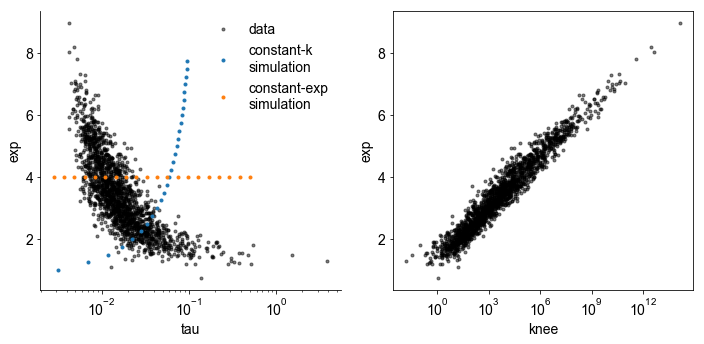

In [581]:
# plot tau-exp correlation
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.semilogx(df_combined['tau'],df_combined['exp'],'.k', alpha=0.5, label='data')
sim_exp = np.arange(1,8,0.25)
k_freq, k_tau = utils.convert_knee_val(knee=50., exponent=sim_exp)
plt.plot(k_tau, sim_exp, '.', label='constant-k\nsimulation')

sim_k,sim_exp = np.logspace(-2,7,20),4
k_freq, k_tau = utils.convert_knee_val(knee=sim_k, exponent=sim_exp)
plt.plot(k_tau, np.ones_like(k_tau)*sim_exp, '.', label='constant-exp\nsimulation')

plt.legend(frameon=False)
plt.xlabel('tau'); plt.ylabel('exp'); utils.remove_spines(plt.gca())
# knee-exp
plt.subplot(1,2,2)
plt.semilogx(df_combined['knee'],df_combined['exp'],'.k', alpha=0.5)
plt.xlabel('knee'); plt.ylabel('exp')
plt.tight_layout()

One immediate note of interest: exponent and time constant are negatively correlated, which is the opposite of what we would expect if purely a product of the time constant formula, i.e. knee remains constant but exponent changes.

This means exponent and time constant are independently changing and in opposite directions, in other words, slope and knee are positively correlated.

Does this recapitulate the Murray finding? Need to match convert the "long timescale" finding to exponent in the autocorrelation simulation.

Higher exponent value means faster dropoff of power in high frequency, i.e. more dominant lower frequency (more "long-timescale" activity), so higher autocorrelation offset?

# Subject and Grand Average
First average over electrodes of the same region for each subject, then average over all subjects.

Can vary the plotted feature and the central tendency measure used. Error bars always denote 2xSEM.

In [34]:
# grand_agg_reg = df_combined.groupby(['region', 'patient']).aggregate(eval(aggr_func))
# df_combined.dropna(inplace=True)

(0.0035, 0.7)

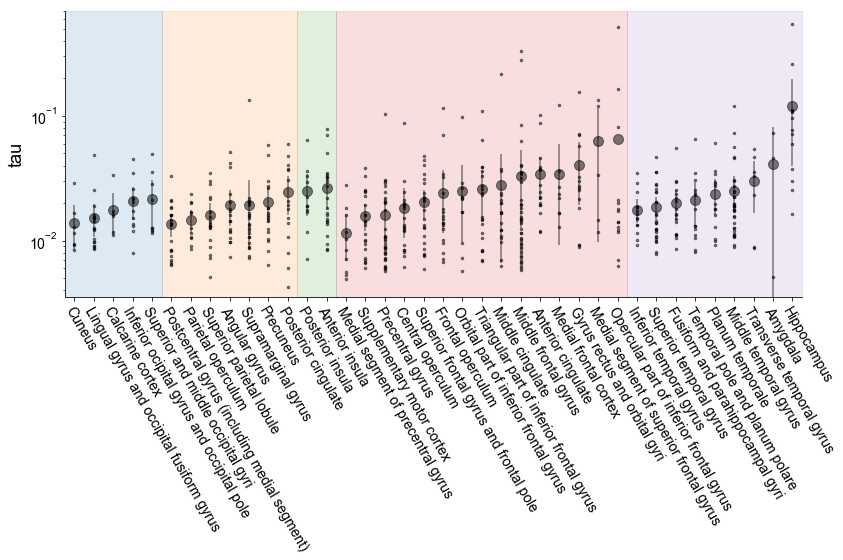

In [35]:
plt.figure(figsize=(12,8))
feature = 'tau'
group_col = [['patient', 'region'], 'region']
aggr_funcs = ['np.mean', 'np.median', 'stats.mstats.gmean']
aggr_func = aggr_funcs[0]
log_y = True

grand_agg_reg, patient_agg_reg = compute_aggregate(df_combined, feature, eval(aggr_func), group_col)
plot_aggregate_by_region(grand_agg_reg, feature, aggr_func, region_labels, patient_agg_reg, 
                         log_y=True, sort_by='avg', plot_vert=False, shade_by_lobe=True)

# the boxes don't draw all the way down for whatever reason
plt.ylim([0.0035, 0.7])

#### Interim conclusion: 
As far as time constants go, these results seem roughly consistent with the monkey results:
- the numbers themselves are in the range of monkey ecog results, i.e. between 10-100ms mostly, as opposed to 100-300ms of population spiking timescales
- frontal regions, especially mFC and ACC, have the longest fitted time constants.
- SMC and pre+postcentral gyrus (somatosensory areas) have the shortest time constants.
- temporal lobe, as a whole, have pretty long time constants. I would've expected at least a short-timescale region in primary auditory cortex, but maybe coverage there isn't good coverage there. Also I have no clue which of those regions correspond to A1.
- hippocampus has an extremely long time constant as a whole, as well as opercular part of IFG (brodmann 44).
- results are fairly consistent across different averaging functions
- did not look extensively across the different PSD estimate and fooof parameter configurations, but comparing 1sec and 5sec median fits seem to be pretty consistent

#### Problems:
- I have no idea where some of these regions are, maybe plot their average coordinates on a brain?
    - see next figure
    - Brad's idea is to plot tau as a function of distance (Euclidean, Haversine, cortical surface, etc.) from electrode to primary sensory/motor region of that lobe, e.g., V1, A1, S1. 
- electrode difference: the 4 types of electrodes may have different impedance spectra, so I should probably regress that out, or at least compare within electrodes
    - see below: general pattern is more or less the same for each electrode type, though coverage does differ
- not really sure what is the best function to use to average/visualize the time constants, because they're non-normally distributed
    - have options for nanmean, nanmedian, and geometric mean, all more or less the same (though scipy geometric mean is messed up because it doesn't account for nans

# Spatial Localization on Brain

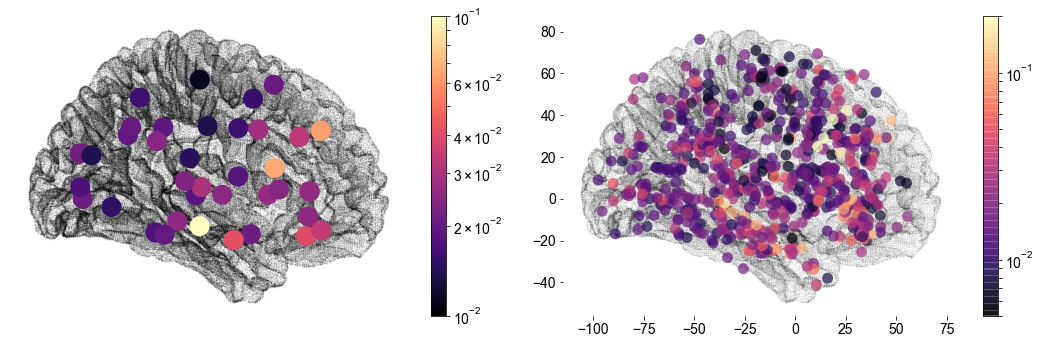

In [36]:
label_region = False
agg_avg, agg_sem = compute_avg_sem(grand_agg_reg, feature, aggr_func)
avg_coor = grand_agg_reg.mean()[['x','y','z']]

plt.figure(figsize=(15,5))

# plot grand average
plt.subplot(1,2,1)
plt.scatter(data_dict['NodesLeft'][:,1],data_dict['NodesLeft'][:,2], s=1, c='k', alpha=0.1) # plot brain
plt.scatter(avg_coor['y'],avg_coor['z'], s=400, c=agg_avg, 
            norm=matplotlib.colors.LogNorm(), edgecolors='none', cmap='magma')

if label_region:
    for i,s in enumerate(region_labels['Region #']):
        plt.text(avg_coor['y'][i+1],avg_coor['z'][i+1], s, color='w', 
                 horizontalalignment='center', verticalalignment='center')
plt.clim([0.01,0.1])
plt.colorbar()
plt.xticks([]);plt.yticks([])
plt.box('off')

# plot regional average from each patients
plt.subplot(1,2,2)
plt.scatter(data_dict['NodesLeft'][:,1],data_dict['NodesLeft'][:,2], s=1, c='k', alpha=0.05)
plt.scatter(patient_agg_reg['y'],patient_agg_reg['z'], s=120, c=patient_agg_reg[feature], 
            norm=matplotlib.colors.LogNorm(), edgecolors='none', cmap='magma', alpha=0.7)
plt.clim([0.005,0.2])
plt.colorbar()
#plt.xticks([]);plt.yticks([])
plt.tight_layout()
plt.box('off')

# Distance from primary area per lobe
To find MNI coordinates for the primary sensorimotor areas for each lobe (V1, A1, S1, M1), I started with [this chart][1] that is kinda off, so I visually confirmed in this [interactive viz][2], then checked in [neurosynth][3] to make sure the associated terms for each coordinate are indeed primary sensory. Finally, [Wikipedia of brodmann area][4].

Package for computing cortical surface distance: [paper][5] & [code][6].
[1]:http://www.ajnr.org/content/ajnr/suppl/2011/02/07/ajnr.A2330.DC1/2330_materials.pdf
[2]:http://sprout022.sprout.yale.edu/mni2tal/mni2tal.html
[3]:http://neurosynth.org/locations/?x=50&y=-24&z=56
[4]:https://en.wikipedia.org/wiki/Brodmann_area
[5]:https://academic.oup.com/gigascience/article/5/suppl_1/s13742-016-0147-0-q/2965222
[6]:https://pypi.org/project/gdist/

/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


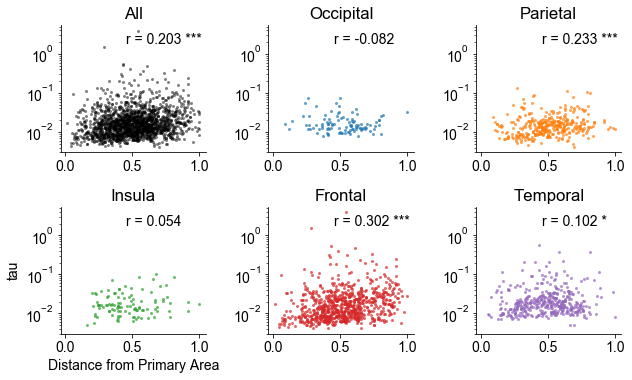

In [37]:
# right hemisphere lobe seeds: V1, S1, insula (BA14), M1, A1 
lobe_seed_coors = np.array([[15, -99, -4], [50, -25, 55], [44, 4, 0], [41, -23, 60], [50, -21, 7]])

grand_agg_reg, patient_agg_reg = compute_aggregate(df_combined, feature, eval(aggr_func), group_col)

# individual electrode
df_w_dist_elec = compute_distance_to_seed(df_combined[df_combined['etype']!=0], lobe_seed_coors, 
                                          seed_by_lobe=True, norm_by_lobe='max')

# plot distance from seed vs. tau for each electrode
plt.figure(figsize=(9,5.5))
plot_from_seeddist(df_w_dist_elec, 'tau', lobe_id, hold_axis=True)

# # --- average over regions in subject, and then over all subjects ---
# # average over all electrodes of same region in each patient
# df_w_dist_pat = compute_distance_to_seed(patient_agg_reg, lobe_seed_coors, seed_by_lobe=True)
# plt.figure(figsize=(12,8))
# plot_from_seeddist(df_w_dist_pat, 'tau', lobe_id, hold_dist_axis=True)

# # average over all electrodes of same region in each patient
# df_w_dist_reg = compute_distance_to_seed(grand_agg_reg.mean(), lobe_seed_coors, seed_by_lobe=True)
# plt.figure(figsize=(12,8))
# plot_from_seeddist(df_w_dist_reg, 'tau', lobe_id, hold_dist_axis=True)

# Redo region plot sorted by distance from primary S/M area

(0.0035, 0.7)

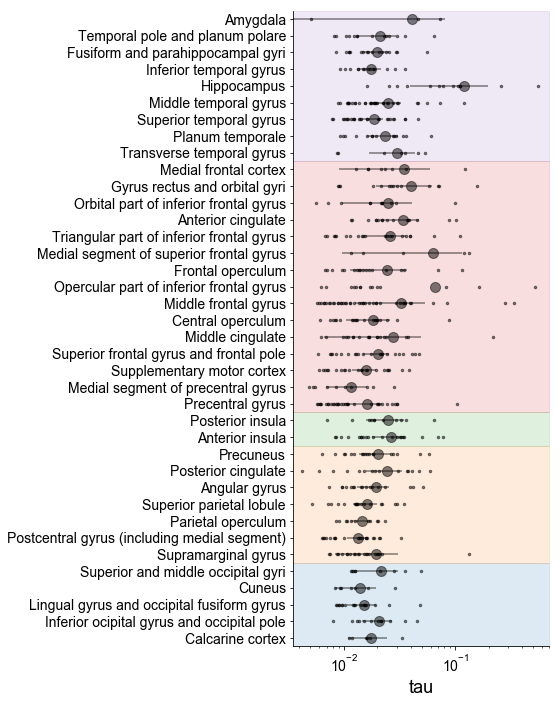

In [38]:
plt.figure(figsize=(8,10))

### ---- average over all electrodes coordinates of same region in each patient, then across all patients
#   then compute distance of that "average electrode" location in each region
# df_w_dist_reg = compute_distance_to_seed(grand_agg_reg.mean(), lobe_seed_coors, seed_by_lobe=True)
# plot_aggregate_by_region(grand_agg_reg, feature, aggr_func, region_labels, patient_agg_reg, 
#                          log_y=True, sort_by=df_w_dist_reg['seed_dist'], shade_by_lobe=True)

### ---- take average of electrode distance from seed
region_avg_seed_dist = df_w_dist_elec.groupby('region')['seed_dist'].mean()
plot_aggregate_by_region(grand_agg_reg, feature, aggr_func, region_labels, patient_agg_reg, 
                         log_y=True, sort_by=region_avg_seed_dist, plot_vert=True, shade_by_lobe=True)

plt.xlim([0.0035, 0.7])

- data from all electrodes without aggregating show positive correlation between time constant and distance from primary region, especially prominent in parietal and frontal lobe
- when aggregating across regions within patient, as well as then across patient, the same trends hold
- overall correlation is weak because there's a lobe dependence of distance from seed, i.e. frontal electrodes have quite a lot of electrodes that are 50-100units away from seed, where as the other lobes do not.
    - can mitigate this by normalizing distance from each seed by lobe
    - run function with norm_by_lobe='max'
    - overall correlation is comparable with frontal and parietal correlation
- **above aggregates are computed such that distance is first computed, then averaged. Can also compute distance of 'average electrode' in the region instead of averaging over distance.**

# Subsample by electrode type

1.0 65 ['P', 'b', 10]
4.0 1182 ['^', 'r', 10]


/Users/rdgao/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/rdgao/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


7.0 256 ['s', 'g', 10]
13.0 262 ['D', 'y', 10]


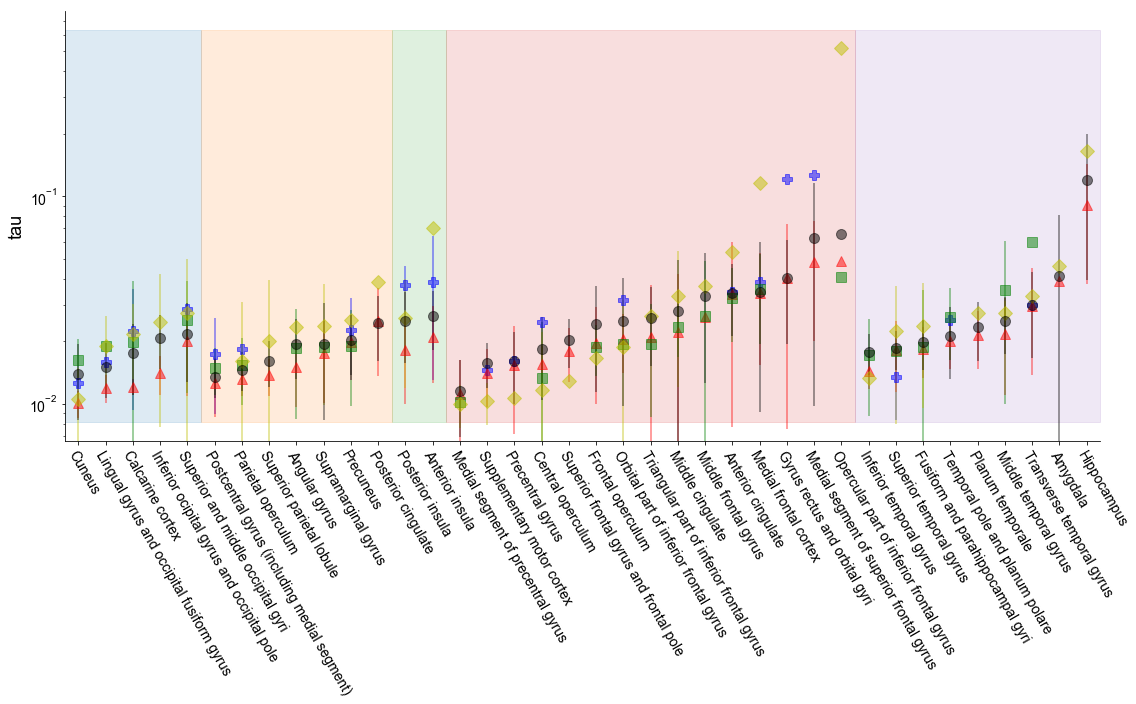

In [39]:
group_col = [['patient', 'region'], 'region']

plt.figure(figsize=(16,10))
# iterate through subsets
m_cfgs = [['P','b',10],['^','r',10],['s','g',10],['D','y',10]]
for i,e in enumerate(np.sort(df_combined['etype'].unique())):
    print(e, sum(df_combined['etype']==e), m_cfgs[i])
    sub_grand_agg_reg, patient_agg_reg = compute_aggregate(df_combined[df_combined['etype']==e], feature, eval(aggr_func), group_col)
    plot_aggregate_by_region(sub_grand_agg_reg, feature, aggr_func, region_labels, m_cfg=m_cfgs[i])

plot_aggregate_by_region(grand_agg_reg, feature, aggr_func, region_labels, shade_by_lobe=True)

- Black circles are grand average, green squares are grid/strip electrodes, the rest (blue/red/yellow) are stereo-EEG.
- It does not look like grid/strip electrodes are significantly different from the rest. Probably should run stats on this.

# Feature vs. Age

/Users/rdgao/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/rdgao/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


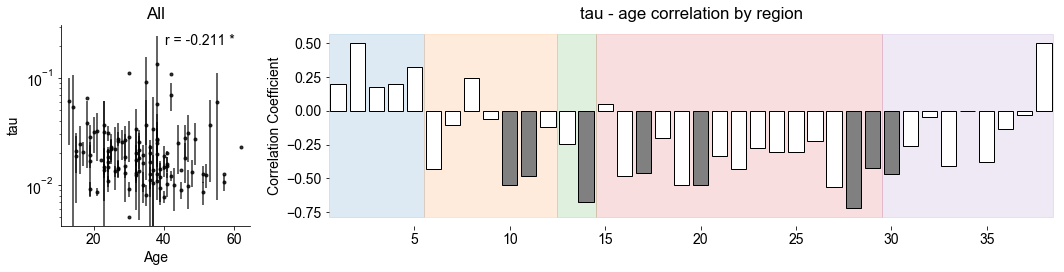

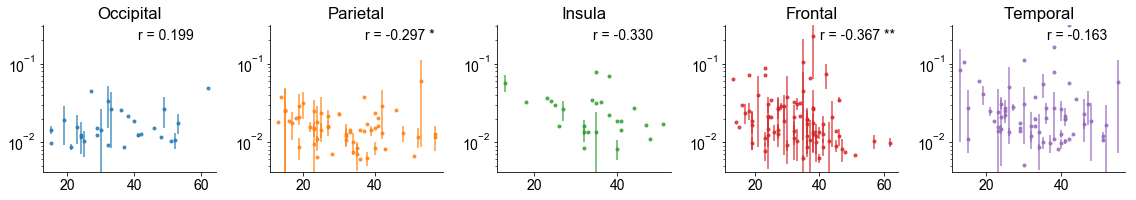

In [664]:
xy_axis_frac = (0.55, 0.9)
feature = 'tau'
group_col = 'patient'
group_col = [['patient', 'region'], 'patient']
aggr_func = aggr_funcs[0]
sig_thres = 0.05
log_y = True
df_age = pd.DataFrame(data_dict['AgeAtTimeOfStudy'],index=df_combined.patient.unique())

plt.figure(figsize=(15,4))
# ---- grand average over patients ----
grand_agg_patient, _ = compute_aggregate(df_combined, feature, eval(aggr_func), group_col)
agg_avg, agg_sem = compute_avg_sem(grand_agg_patient, feature, aggr_func)
rho, pv = stats.spearmanr(df_age.loc[np.array(agg_avg.index).astype(int),0], agg_avg, nan_policy='omit')
s = 'r = %.3f '%rho + np.sum(pv<=np.array([0.05, 0.01, 0.001]))*'*'

plt.subplot2grid((1, 4), (0, 0),colspan=1)
plt.errorbar(df_age.loc[np.array(agg_avg.index).astype(int),0], agg_avg, agg_sem*2, fmt='.k', alpha=0.8)
plt.xlabel('Age'); plt.ylabel(feature); plt.title('All'); 
plt.annotate(s, xy=xy_axis_frac, xycoords='axes fraction', size=14)
#plt.gca().spines['right'].set_visible(False); plt.gca().spines['top'].set_visible(False)
utils.remove_spines(plt.gca())
if log_y: plt.yscale('log')
YL_scatter = plt.ylim()

# ---- average per region ----
plt.subplot2grid((1, 4), (0, 1),colspan=4)
for ind, region in enumerate(np.sort(df_combined['region'].unique())):
    sub_agg_reg, _ = compute_aggregate(df_combined[df_combined['region']==region], feature, eval(aggr_func), group_col)
    agg_avg, agg_sem = compute_avg_sem(sub_agg_reg, feature, aggr_func)
    rho, pv = stats.spearmanr(df_age.loc[np.array(agg_avg.index).astype(int),0], agg_avg, nan_policy='omit')
    plt.bar(region, rho, ec='k', fc='w' if pv > sig_thres else 'gray')
    

# plot shading for lobe
YL = plt.ylim()
lobe_boundaries = np.sort(np.array([region_labels.groupby('Lobe')['Region #'].min(), region_labels.groupby('Lobe')['Region #'].max()]))
for i,l in enumerate(lobe_boundaries.T):
    plt.fill_between([l[0]-0.5, l[1]+0.5], YL[0], YL[1], alpha=0.15, color=C_ORD[i])

    
plt.xlim([region_labels['Region #'].min()-0.5, region_labels['Region #'].max()+0.5])
plt.ylabel('Correlation Coefficient')
plt.title(feature+' - age correlation by region')
plt.box('off')
plt.tight_layout()

# ---- per lobe --- #
plt.figure(figsize=(16,3))
for ind, lobe in enumerate(lobe_id.keys()):
    sub_agg_lobe, _ = compute_aggregate(df_combined[df_combined['lobe']==lobe_id[lobe]], feature, eval(aggr_func), group_col)
    agg_avg, agg_sem = compute_avg_sem(sub_agg_lobe, feature, aggr_func)
    plt.subplot2grid((1, 5), (0, ind))
    plt.errorbar(df_age.loc[np.array(agg_avg.index).astype(int),0], agg_avg, agg_sem*2, fmt='.', color=C_ORD[ind], alpha=0.8)
    if log_y: plt.yscale('log')
    rho, pv = stats.spearmanr(df_age.loc[np.array(agg_avg.index).astype(int),0], agg_avg, nan_policy='omit')    
    s = 'r = %.3f '%rho + np.sum(pv<=np.array([0.05, 0.01, 0.001]))*'*'
    plt.annotate(s, xy=xy_axis_frac, xycoords='axes fraction', size=14)    
    plt.title(lobe); plt.ylim(YL_scatter)
    utils.remove_spines(plt.gca())

plt.tight_layout()

Long term structural/gene expression changes in aging correlates with functional timescales
- PV expression is negatively correlated with timescale; NR2B positively
- PV is increased in primary sensory (visual) cortices; NR2B in association cortices
- PV & NR2 expression both decrease with age
- timescale increases in VC with age, decreases everywhere else, esp frontal

# Compare with gene expression and T1w/T2w maps

In [433]:
anat_basepath = '/Users/rdgao/Documents/data/GeneMyelin/'
# load myelin data
df_myelin = pd.read_csv(anat_basepath+'Glasser_labels_L.txt', sep='\t', index_col=0, header=None, names=['region'])
myelin_val = io.loadmat(anat_basepath+'myelin.mat', squeeze_me=True)['myelin']
df_myelin.insert(loc=1, column='T1T2', value=myelin_val)

# load gene expression data
gene_data = io.loadmat(anat_basepath+'gdat.mat', squeeze_me=True)
df_gene= pd.DataFrame(gene_data['gdat'].T, columns=gene_data['lab'][:,0])

# combine
df_anat = pd.concat((df_myelin.reset_index()[['region', 'T1T2']], df_gene), axis=1)
df_anat.index+=1

- https://www.lead-dbs.org/helpsupport/knowledge-base/atlasesresources/cortical-atlas-parcellations-mni-space/
- https://neurovault.org/collections/1549/
- https://figshare.com/articles/HCP-MMP1_0_projected_on_MNI2009a_GM_volumetric_in_NIfTI_format/3501911
- https://nipy.org/nibabel/gettingstarted.html
- info on sform: https://nifti.nimh.nih.gov/nifti-1/documentation/nifti1fields/nifti1fields_pages/qsform.html
- info on afffines: https://nipy.org/nibabel/nifti_images.html
- **get region from coordinate**: https://neurostars.org/t/get-region-of-brain-from-coordinates/1594
- **vlume to surface mapping**: https://github.com/ThomasYeoLab/CBIG/tree/master/stable_projects/registration/Wu2017_RegistrationFusion

- sform code is 2, but code 4 is MNI?
- get_best_affine() or get_affine() give the same thing, so this seems to be the index to xyz transformation

In [376]:
import nibabel as nib
#MMP_data = nib.load(anat_basepath+'MMP 1.0 MNI projections/MMP_in_MNI_corr.nii.gz')
#MMP_data = nib.load(anat_basepath+'MMP 1.0 MNI projections/HCPMMP1_on_MNI152_ICBM2009a_nlin_hd.nii.gz')
MMP_data = nib.load(anat_basepath+'MMP 1.0 MNI projections/MMP_in_MNI_symmetrical_1.nii.gz')
MMP_map = np.asarray(MMP_data.get_data())
M_aff, M_trsl = MMP_data.affine[:3,:3], MMP_data.affine[:3,-1]

In [385]:
def apply_affine(f_affine, coord, ijk2xyz):
    M_aff, M_trsl = f_affine[:3,:3], f_affine[:3,-1]
    if ijk2xyz:
        # index to MNI coordinate
        return np.dot(M_aff,coord)+M_trsl
    else:
        # MNI coordinate to index
        return np.dot(np.linalg.inv(M_aff),coord-M_trsl)

The strategy here, I think, is to:

(winner take all)
- first, find the voxels closest to the given coordinate that has non-zero parcellation values, with parameter k-nearest
- second, grab the most common parcellation value to assign to that electrode
- use that parcellation value to find the corresponding expression/T1T2 values

(by committee)
alternatively:
- grab all parcellation values within some k-nearest neighbor voxels
- average the T1T2 (or expression) values over those voxels to assign to the electrode

Either way, need a function that finds the neighbors in space given a coordinate

In [151]:
# using KD tree to do the nearest coordinate search
# there must be a cleverer/faster way of doing this but this works well enough. 
# Even though the tree building is very slow, search is extremely fast.
map_dim = MMP_map.shape
x_ax,y_ax,z_ax = np.mgrid[0:map_dim[0],0:map_dim[1],0:map_dim[2]]
points_flatten = np.c_[x_ax.ravel(), y_ax.ravel(), z_ax.ravel()]
tree = spatial.KDTree(points_flatten)

In [769]:
parcel_coords = []
for r_i, row in df_combined.iterrows():
    # METHOD 1:
    # find the nearest coordinates in radius r_search using KDTree
    # this will return non-integer values because of the offset, 
    # and some of the electrode coords are non-integer in the first place
    r_search = 2
    i,j,k = apply_affine(MMP_data.affine, row[['x','y','z']].values, False)
    nearest_coords = tree.query_ball_point([i,j,k], r_search)
    parcel_coords.append([(np.linalg.norm(c-[i,j,k]), MMP_map[tuple(c)]) for c in points_flatten[nearest_coords,:]])
    
    # METHOD 2: old method: round to integer and find one voxel
#     i,j,k = apply_affine(MMP_data.affine, row[['x','y','z']].values, False).astype(int)
#     parcel_coords.append((0, MMP_map[i,j,k]))

    # METHOD 3:
    # round to integer and find surround cube with length l_cube*2+1
    # not the most precise way of doing it
#     l_cube=3
#     i_,j_,k_ = apply_affine(MMP_data.affine, row[['x','y','z']].values, False)
#     i,j,k = int(i_), int(j_), int(k_)
#     cube_x,cube_y,cube_z = np.mgrid[i-l_cube:i+l_cube+1, j-l_cube:j+l_cube+1, k-l_cube:k+l_cube+1]
#     cube_flatten = np.c_[cube_x.ravel(), cube_y.ravel(), cube_z.ravel()]
#     parcel_coords.append([(np.linalg.norm(c-[i_,j_,k_]), MMP_map[tuple(c)]) for c in cube_flatten])
    

# get the parcels given a ball of voxels, more robust
parcels = np.ones(len(parcel_coords))*np.nan
for i_p, p in enumerate(parcel_coords):
    # get the counts and parcel ID of nearest voxels
    p_counts = np.array(np.unique(np.array(p)[:,1], return_counts=True)).T
    p_gm = np.sort(p_counts[p_counts[:,0]!=0,:], axis=0)
    if p_gm.shape[0]:
        parcels[i_p] = int(p_gm[-1,0])

# update parcel column in df
if 'gparcel' in df_combined:
    df_combined['gparcel'] = parcels
else:
    df_combined.insert(10, 'gparcel', parcels)

# Parcel averaged ephys values

In [770]:
df_anat.columns

Index(['region', 'T1T2', 'ADRA1A', 'ADRA1B', 'ADRA1D', 'ADRA2A', 'ADRA2B',
       'ADRA2C', 'ADRB1', 'ADRB2', 'ADRB3', 'DRD1', 'DRD2', 'DRD3', 'DRD4',
       'DRD5', 'CHRM1', 'CHRM2', 'CHRM3', 'CHRM4', 'CHRM5', 'CHRNA10',
       'CHRNA2', 'CHRNA3', 'CHRNA4', 'CHRNA5', 'CHRNA6', 'CHRNA7', 'CHRNA9',
       'CHRNB2', 'CHRNB3', 'HTR1A', 'HTR1B', 'HTR1D', 'HTR1E', 'HTR1F',
       'HTR2A', 'HTR2B', 'HTR2C', 'HTR3A', 'HTR3B', 'HTR3C', 'HTR4', 'HTR5A',
       'HTR6', 'HTR7', 'GRIA1', 'GRIA2', 'GRIA3', 'GRIA4', 'GRIN1', 'GRIN2A',
       'GRIN2B', 'GRIN2C', 'GRIN2D', 'GRIN3A', 'GRIN3B', 'GRM1', 'GRM2',
       'GRM3', 'GRM4', 'GRM5', 'GRM6', 'GRM7', 'GRM8', 'GRID1', 'GRID2',
       'GRIK1', 'GRIK2', 'GRIK3', 'GRIK4', 'GRIK5', 'GABRA1', 'GABRA2',
       'GABRA3', 'GABRA4', 'GABRA5', 'GABRA6', 'GABRB1', 'GABRB2', 'GABRB3',
       'GABRD', 'GABRE', 'GABRG1', 'GABRG2', 'GABRG3', 'GABRP', 'GABRQ',
       'GABRR1', 'GABRR3', 'VIP', 'PV+', 'SOM'],
      dtype='object')

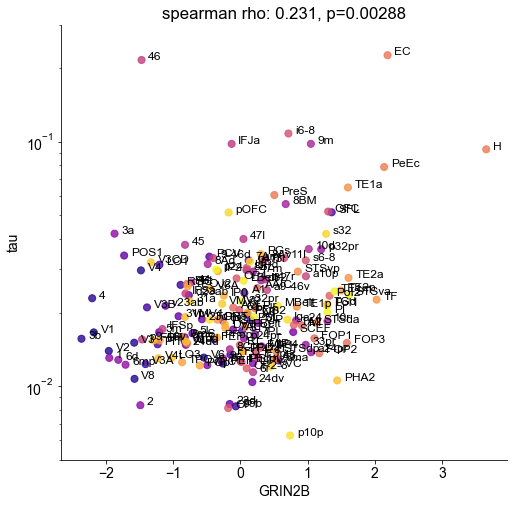

In [882]:
label_on_plt = True
anat_feat = 'GRIN2B'
ephys_feat = 'tau'
age_subset = np.logical_and(df_combined['age']>=0,df_combined['age']<=100)
parcel_avg = df_combined[age_subset].groupby('gparcel').aggregate(eval(aggr_funcs[0]))
c_grad = plt.cm.plasma((parcel_avg.index)/max(parcel_avg.index)) # color gradient based on parcel number
x, y = df_anat[anat_feat][parcel_avg.index], parcel_avg[ephys_feat]
plt.figure(figsize=(8,8))
plt.scatter(x,y,s=50, c=c_grad, alpha=0.8)
if label_on_plt: [plt.text(x[p_i]+0.1, y[p_i], df_anat.loc[p_i]['region'][2:-4], fontsize=12) for p_i in x.index]
plt.xlabel(anat_feat); plt.ylabel(ephys_feat); utils.remove_spines(plt.gca())
plt.yscale('log'); plt.ylim([5e-3, .3])
plt.title(('spearman rho: %.3f, p=%.5f')%stats.spearmanr(x, y, nan_policy='omit'));

(array([ 7., 42., 39., 21., 17., 12., 10.,  2.,  2.,  0.,  3.,  1.,  1.,
         1.,  0.,  0.,  1.,  0.,  0.,  1.,  2.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([0.00628793, 0.01067327, 0.0150586 , 0.01944394, 0.02382927,
        0.02821461, 0.03259995, 0.03698528, 0.04137062, 0.04575595,
        0.05014129, 0.05452663, 0.05891196, 0.0632973 , 0.06768264,
        0.07206797, 0.07645331, 0.08083864, 0.08522398, 0.08960932,
        0.09399465, 0.09837999, 0.10276532, 0.10715066, 0.111536  ,
        0.11592133, 0.12030667, 0.12469201, 0.12907734, 0.13346268,
        0.13784801, 0.14223335, 0.14661869, 0.15100402, 0.15538936,
        0.15977469, 0.16416003, 0.16854537, 0.1729307 , 0.17731604,
        0.18170138, 0.18608671, 0.19047205, 0.19485738, 0.19924272,
        0.20362806, 0.20801339, 0.21239873, 0.21678406, 0.2211694 ,
        0.22555474]),
 <a list of 50

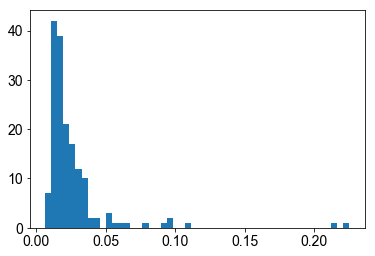

In [881]:
plt.hist(y,50)

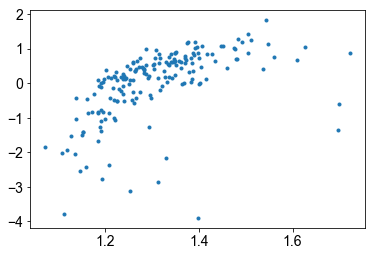

In [845]:
plt.plot(df_anat['T1T2'], df_anat['PV+'], '.')

In [831]:
df_anat[df_anat['T1T2']>0]

,region,T1T2,ADRA1A,ADRA1B,ADRA1D,ADRA2A,ADRA2B,ADRA2C,ADRB1,ADRB2,...,GABRG1,GABRG2,GABRG3,GABRP,GABRQ,GABRR1,GABRR3,VIP,PV+,SOM
1,L_V1_ROI,1.542435,0.445516,-4.085489,-2.359457,3.629813,-0.859787,-2.935093,1.718791,-2.127824,...,-2.722288,2.873943,3.208588,-1.373687,-0.713774,0.523630,-0.048087,-1.826850,1.819187,-2.434811
2,L_MST_ROI,1.480494,-0.743004,-0.501980,0.420120,0.419766,-0.655174,-0.726474,1.127024,-0.731560,...,-0.062323,1.176509,-0.050929,0.266411,-0.498754,-0.316409,-0.985247,0.207635,0.708244,-0.677743
3,L_V6_ROI,1.492422,-0.298808,-1.373979,-0.008745,0.293729,0.312248,-1.531110,1.767117,-1.686118,...,-2.089770,1.714445,1.458583,-1.125744,-0.694446,-1.399404,-0.572891,0.168934,1.194688,-1.506535
4,L_V2_ROI,1.504715,0.483145,-3.309110,-1.352767,2.565679,-1.010420,-2.493298,1.791312,-2.026265,...,-1.764833,2.771500,2.739878,-1.083422,-0.677311,0.351544,-0.028236,-1.332758,1.419205,-2.263945
5,L_V3_ROI,1.482460,-0.303466,-2.577553,-0.400316,1.607716,-1.426117,-2.161167,1.553658,-1.811237,...,-1.528323,1.920533,2.208448,-0.588894,-0.791734,0.301432,-0.594852,-1.072595,1.279658,-1.959311
6,L_V4_ROI,1.446608,-0.181402,-2.307530,0.112529,1.036786,-1.406520,-2.261417,0.972557,-1.520727,...,-1.333264,1.138153,1.542840,-0.111967,-0.870504,0.239905,-0.031948,-1.004959,1.078034,-1.597826
7,L_V8_ROI,1.428088,0.673191,-1.453058,0.613922,-0.294352,-1.783134,-1.773520,0.273131,-1.467058,...,0.214422,0.494668,0.358358,1.026494,-0.828031,-0.475242,0.597178,-0.678155,0.836319,-0.934598
8,L_4_ROI,1.625340,0.641472,-0.033619,0.272347,0.365533,-0.949220,-0.827261,-0.711836,-0.614493,...,-1.712990,-0.079589,-0.265281,1.572430,-0.632514,0.347924,0.369491,-2.039570,1.043511,-0.798041
9,L_3b_ROI,1.546964,0.532918,-0.523159,-0.039721,0.498799,-0.840980,-0.946967,-0.340227,-0.676190,...,-1.221722,0.131990,0.093087,1.179770,-0.686768,0.160909,-0.052685,-1.734901,1.126248,-0.715132
10,L_FEF_ROI,1.386515,-0.017839,0.620561,0.809461,0.536638,0.400427,0.182764,-0.192132,0.220791,...,-1.827278,-0.191928,-0.292726,1.134682,-0.561629,1.004404,1.512973,-1.483405,0.882150,-0.068520


# electrode level correlation

1399


SpearmanrResult(correlation=-0.15877063783089465, pvalue=masked_array(data=2.54883315e-09,
             mask=False,
       fill_value=1e+20))

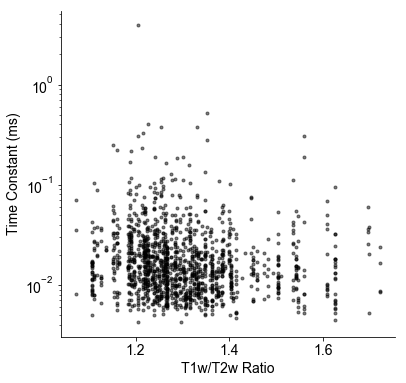

In [403]:
T1T2 = np.array([df_anat.iloc[int(p_i-1)]['T1T2'] if p_i else np.nan for p_i in parcels])
print(sum(~np.isnan(T1T2)))
plt.figure(figsize=(6,6))
plt.semilogy(T1T2, df_combined['tau'], 'k.', alpha=0.5)
plt.xlabel('T1w/T2w Ratio');plt.ylabel('Time Constant (ms)')
utils.remove_spines(plt.gca())

stats.spearmanr(T1T2, df_combined['tau'], nan_policy='omit')

Text(0,0.5,'Time constant (s)')

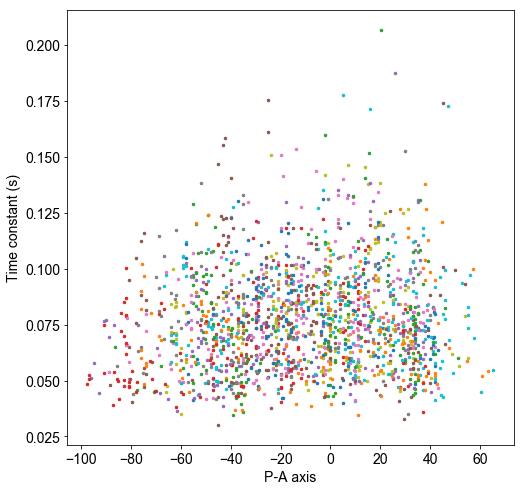

In [112]:
# 'D' for Dixi intracerebral electrodes
# 'M' for homemade MNI intracerebral electrodes
# 'A' fro AdTech intracerebral electrodes 
# 'G' for AdTech subdural strips and grids
plt.figure(figsize=(8,8))
inds = np.logical_and(data_dict['ChannelType']=='M',~np.isnan(knee_freq))
for p in np.unique(data_dict['Patient']):
    inds = np.logical_and(data_dict['Patient']==p,~np.isnan(knee_freq))
    plt.plot(data_dict['ChannelPosition'][inds,1], fg_err[inds], '.', ms=5)

plt.xlabel('P-A axis')
plt.ylabel('Time constant (s)')

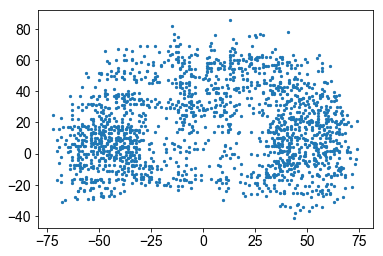

In [113]:
ind = data_dict['ChannelPosition'][:,0]>=-np.inf
plt.scatter(data_dict['ChannelPosition'][ind,0], data_dict['ChannelPosition'][ind,2], 5)